# Sentiment 140 Twitter Sentiment Analysis

I will be using the sentiment140 dataset from http://help.sentiment140.com/for-students/. It contains 1.6 million tweets labeled as negative (0) or positive (4). The website says there are tweets labeled neutral (2), but I could not find these in the emoji-cleaned data.

## Setup

Get packages

In [1]:
import torch
import numpy as np
import pandas as pd
import nltk
nltk.download('words')

from tqdm import tqdm

[nltk_data] Downloading package words to /Users/arths/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')
print(device)

cpu


Get sentiment140 dataset from http://help.sentiment140.com/for-students/

In [3]:
# Uncomment if using colab
# !pip install wget
# !pip install transformers

In [4]:
def download_dataset(url, rename_stem='sentiment140'):
    import wget
    import zipfile
    import os

    data_zip_path = f'{rename_stem}.zip'
    data_dir = f'{rename_stem}/'

    if not os.path.exists(data_zip_path):
        wget.download(url, data_zip_path)
    if not os.path.exists(data_dir):
        with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

In [5]:
DATA_URL = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
download_dataset(DATA_URL)

## Data Loading and Cleaning

In [6]:
def cleaner(tweet, valid_words=set()):
     import re

     # Remove @ sign and @s
     tweet = re.sub('@[A-Za-z0-9]+', '', tweet)
     tweet = re.sub('@', '', tweet)

     # Remove http/https links
     tweet = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', '', tweet)
     tweet = ' '.join(tweet.split())
     
     # Remove hashtag sign but keep the text
     tweet = tweet.replace('#', '').replace('_', ' ')

     # accept only valid words from nltk
     tweet = ' '.join(w for w in nltk.wordpunct_tokenize(tweet) \
                      if w.lower() in valid_words or not w.isalpha())
     
     tweet = tweet.lower()
     
     return tweet

In [7]:
columns = ['polarity', 'id', 'date', 'query', 'username', 'tweet']
df = pd.read_csv('./sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding="ISO-8859-1", header=None, names=columns)

In [8]:
len(df.index[df['polarity'] == 4].tolist())

800000

In [9]:
valid_words = set(nltk.corpus.words.words())
tqdm.pandas()
df['tweet'] = df['tweet'].progress_map(lambda x: cleaner(x, valid_words=valid_words))

100%|██████████| 1600000/1600000 [00:15<00:00, 102243.27it/s]


In [10]:
# to match output convention later
df.loc[df['polarity'] == 4, 'polarity'] = 1
print(df['polarity'].unique())

[0 1]


In [11]:
print('duplicated:', df.duplicated().sum())
print('null:', df.notnull().sum(), sep='\n')

duplicated: 0
null:
polarity    1600000
id          1600000
date        1600000
query       1600000
username    1600000
tweet       1600000
dtype: int64


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   tweet     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
df.sample(10)[['polarity', 'tweet']]

,polarity,tweet
239762,0,much more reading to do .. yet little time left .
509883,0,i want another tattoo so badly
303158,0,aw mang . i see up so bad ... ha i be blown as...
1491833,1,"as hard as it was to choose , i chose sleep ! ..."
1226893,1,i agree completely !!!! my body is at me for u...
1506337,1,i alan mum ;) ' although not as much
879397,1,still don ' t have a clue bout football but sh...
164195,0,i dont get out of bed i go back to sleep .. i ...
720635,0,is so over this baby bump
1420413,1,i 2 to meet and i don ' t even remember what s...


In [14]:
X = df['tweet'].values
y = df['polarity'].values

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2023)

## BERTTokenizer + Pytorch Dataset

In [16]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print('Loaded!')

Loading BERT tokenizer...
Loaded!


Get longest tokenized sentence (since BERT requires all sentences to be the same length). This includes the special tokens `[CLS]` and `[SEP]`.

In [17]:
# max_len = 0

# # For every sentence...
# for sample in tqdm(X):

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sample, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

#     del input_ids

# print('\nMax sentence length: ', max_len)

# NOTE: the above is on CPU, so uncomment only if using different or new data
max_len = 256

Using BERT Tokenizer and maxlen to tokenize each sentence by

1. tokenize by id
2. prepend `[CLS]`
3. append `[SEP]` at end
4. pad with `[PAD]` tokens until max_len
5. attention mask for the `[PAD]` tokens

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

In [19]:
class BertTokenizedTweetsDataset(Dataset):
    def __init__(self,
                 X_train=X_train, y_train=y_train,
                 X_test=X_test, y_test=y_test,
                 train=True, max_len=256, max_cache_size=800000):
        self.df = df
        self.train = train
        self.max_len = 256

        self.X = X_train if self.train else X_test
        self.y = y_train if self.train else y_test

        self.cache = dict()
        self.max_cache_size = max_cache_size

    def __getitem__(self, index):

        if index in self.cache.keys():
            return self.cache[index]

        X_sample = self.X[index]
        y_sample = torch.tensor(self.y[index], dtype=torch.int64)

        encoded_dict = tokenizer.encode_plus(
                        X_sample,                 # Sentence to encode.
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        max_length=self.max_len,  # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length=True,
                        return_attention_mask=True,   # Construct attn. masks.
                        return_tensors='pt',      # Return pytorch tensors.
                    )
    
        X_tokenized_id = encoded_dict['input_ids']
        X_mask = encoded_dict['attention_mask']

        if len(self.cache) >= self.max_cache_size:
            self.cache.popitem()

        self.cache[index] = (X_tokenized_id, X_mask, y_sample)

        return X_tokenized_id, X_mask, y_sample

    def __len__(self):
        return len(self.X)

In [20]:
train_data = BertTokenizedTweetsDataset(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, train=True)
test_data = BertTokenizedTweetsDataset(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, train=False)

In [21]:
def test_cached_speed(unused_index):
    import time
    def get_time():
        stime = time.time()
        _ = train_data[unused_index]
        etime = time.time()

        return np.array(etime, dtype=np.float64) - np.array(stime, dtype=np.float64)
    
    uncached = get_time()
    cached = get_time()
    speed_x = uncached / cached

    print(f'On this trial, cached had {uncached:.5f}/{cached:.5f} = {speed_x:.5f}x speed increase')    

In [22]:
test_cached_speed(np.random.randint(0, len(train_data)-1))

On this trial, cached had 0.00324/0.00000 = 1697.12500x speed increase


/Users/arths/opt/anaconda3/envs/bert-transfer-learning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Transfer Learning w/ BERT

In [23]:
from torch.utils.data import random_split
train_subset, val_subset = random_split(train_data, [0.8, 0.2])

In [24]:
BATCH_SIZE = 32
EPOCHS=4

In [25]:
train_dl = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

In [26]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def save(model, optimizer, scheduler, save_path='./bert_sentiment140_fine_tuned.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, save_path)

def train_step(bert, dataloader, optimizer, scheduler, epoch=0, val=False, print_batch_every=1000, save_every=10, save_path=None):

    # tracking vars
    tot_accuracy = 0
    tot_loss = 0
    batch = 0

    # ready for train
    if not val:
        bert.train()
    else:
        bert.eval()

    prepend = 'val' if val else 'train'

    for data in iter(dataloader):

        batch += 1

        # get data and send to gpu
        seqs, masks, labels = data

        # align dims
        seqs = torch.squeeze(seqs.transpose(2, 1)).to(device)
        masks = torch.squeeze(masks.transpose(2, 1)).to(device)
        labels = torch.squeeze(labels).to(device)

        if not val:
            # zero out grads
            bert.zero_grad()

        # get loss and preds
        loss, preds = bert(
            seqs,
            attention_mask=masks,
            labels=labels,
            return_dict=False
        )
        
        # calc and accumulate loss
        if not val:
            loss.backward()
        tot_loss += loss.item()

        # torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)

        if not val:
            # descent step + set lr
            optimizer.step()
            scheduler.step()

        pred_sentiment = preds.data.max(1)[1]
        correct = pred_sentiment.eq(labels).cpu().sum()
        accuracy = correct.item() / labels.size(0)
        tot_accuracy += accuracy

        if save_path and ((batch-1) % save_every == 0):
            batch_save_path = save_path[:-4] + f'_{batch}.pth'
            save(bert, optimizer, scheduler, save_path=batch_save_path)

        if ((batch - 1) % print_batch_every == 0):
            print(f'epoch: {epoch}\tbatch: {batch}/{len(dataloader)}\t{prepend}_acc: {accuracy}\t{prepend}_loss: {loss.item()}')

    tot_accuracy = tot_accuracy / len(dataloader)
    tot_loss = tot_loss / len(dataloader)

    print(f'{prepend} epoch: {epoch}\t{prepend}_acc: {tot_accuracy}\t{prepend}_loss: {tot_loss}')
    
    return tot_accuracy, tot_loss

def load(model, optimizer, scheduler, load_path='./bert_sentiment140_fine_tuned.pth'):
    checkpoint = torch.load(load_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return model, optimizer, scheduler

def train(bert, train_dl, val_dl, epochs=4, lr=2e-5, eps=1e-8, print_batch_every=1000, save_every=10, save_path='./bert_sentiment140_fine_tuned.pth'):

    optimizer = AdamW(bert.parameters(), lr=lr, eps=eps)
    
    total_steps = len(train_dl) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_accs, train_losses, val_accs, val_losses = [], [], [], []

    save(bert, optimizer, scheduler, save_path=save_path)

    for epoch in range(epochs):

        batch_save_path = save_path[0:-4] + f'_{epoch}.pth'
        train_accuracy, train_loss = train_step(
            bert, train_dl,
            optimizer, scheduler,
            epoch=epoch,
            print_batch_every=print_batch_every,
            save_every=save_every,
            save_path=batch_save_path
        )

        epoch_save_path = save_path[0:-4] + f'_{epoch}.pth'
        save(bert, optimizer, scheduler, save_path=epoch_save_path)

        val_accuracy, val_loss = 0, 0
        with torch.no_grad():
            val_accuracy, val_loss = train_step(
                bert, val_dl,
                optimizer, scheduler,
                epoch=epoch,
                print_batch_every=print_batch_every,
                val=True,
            )

        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        val_accs.append(val_accuracy)
        val_losses.append(val_loss)

        np.savetxt('checkpoints/train_accs.txt', np.array(train_accs))
        np.savetxt('checkpoints/train_losses.txt', np.array(train_losses))
        np.savetxt('checkpoints/val_accs.txt', np.array(val_accs))
        np.savetxt('checkpoints/val_losses.txt', np.array(val_losses))

    return train_accs, train_losses, val_accs, val_losses

In [27]:
from transformers import DistilBertForSequenceClassification
# load DistilBert model and send to gpu
bert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(df['polarity'].unique()),
    output_attentions=False, output_hidden_states=False,
)
bert.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [28]:
train_accs, train_losses, val_accs, val_losses = train(bert, train_dl, val_dl, epochs=EPOCHS,
                                                       print_batch_every=100, save_every=1000, 
                                                       save_path='./checkpoints/bert_sentiment140_fine_tuned.pth')

## Analysis and Inference

In [ ]:
# TODO: Add code to download selected checkpoints from gdrive

First, we'll load the accuracy and losses for train vs val from saved files and plot.

In [29]:
def load_model(load_path, epochs=1, lr=2e-5, eps=1e-8):
    trained_bert = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=len(df['polarity'].unique()),
        output_attentions=False, output_hidden_states=False,
    )
    trained_bert.to(device)

    optimizer = AdamW(bert.parameters(), lr=lr, eps=eps)
        
    total_steps = len(train_dl) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    trained_bert, optimizer, scheduler = load(trained_bert, optimizer, scheduler, load_path=load_path)

    return trained_bert, optimizer, scheduler

def load_train_stats(load_dir, files=['train_accs', 'train_losses', 'val_accs', 'val_losses']):
    from pathlib import Path

    stats = [np.loadtxt(Path(load_dir) / Path(f'{fn}.txt')) for fn in files]

    return stats

In [30]:
train_accs, train_losses, val_accs, val_losses = load_train_stats('select_saved_checkpoints')

In [31]:
import matplotlib.pyplot as plt

def train_val_plot(plot, train_data, val_data,
                   x_label='', y_label='',
                   train_legend='', val_legend='',
                   train_color='blue', val_color='red',
                   title=''):
    
    
    xs = range(1, len(train_data)+1)
    plot.set_xticks(xs)
    
    plot.plot(xs, train_data, label=train_legend, color=train_color)
    plot.plot(xs, val_data, label=val_legend, color=val_color)

    plot.set_xlabel(x_label)
    plot.set_ylabel(y_label)

    plot.set_title(title)
    plot.legend()

/var/folders/bm/v9sftty97f1b1pjtvxw68byc0000gn/T/ipykernel_82788/3677851923.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


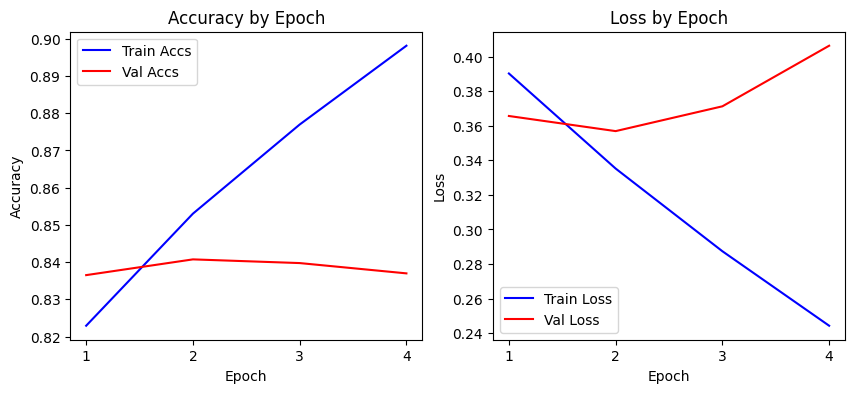

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

train_val_plot(axs[0], train_accs, val_accs,
               x_label='Epoch', y_label='Accuracy', 
               train_legend='Train Accs', val_legend='Val Accs',
               title='Accuracy by Epoch')

train_val_plot(axs[1], train_losses, val_losses,
               x_label='Epoch', y_label='Loss', 
               train_legend='Train Loss', val_legend='Val Loss',
               title='Loss by Epoch')

fig.show()

Notably, after only one epoch our accuracy on validation data reaches about 85%. Furthermore, after the second epoch, the model begins to overfit and val accuracy suffers. So, the optimal version of this fine-tuned model is that from epoch 1.

Next, to minimize computational cost, I will only perform inference on a subset of train data.

Furthermore, in the final table, I will set "negative" training data to -1 rather than 0 for visualization purposes.

In [33]:
optimal_bert, _, _ = load_model('./select_saved_checkpoints/bert_sentiment140_fine_tuned_1.pth')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [34]:
import random

NUM_INFERENCE_SAMPLES = 100

indices = random.sample(range(len(X_test)), NUM_INFERENCE_SAMPLES)

X_inf = [X_test[i] for i in indices]
y_inf = [y_test[i] for i in indices]

In [35]:
inf_data = BertTokenizedTweetsDataset(X_test=X_inf, y_test=y_inf, train=False)
inf_dl = DataLoader(inf_data, batch_size=10, shuffle=False)

In [36]:
def inference(bert, dataloader, sent_data):
    import warnings
    warnings.filterwarnings('ignore')
    with torch.no_grad():

        res_df = pd.DataFrame(columns=['Tweet', 'Label', 'Prediction', 'Approx Sent'])

        data_index = 0
        
        # tracking vars
        tot_accuracy = 0
        tot_loss = 0
        batch = 0

        for data in tqdm(iter(dataloader)):

            batch += 1

            # get data and send to gpu
            seqs, masks, labels = data

            # align dims
            seqs = torch.squeeze(seqs.transpose(2, 1)).to(device)
            masks = torch.squeeze(masks.transpose(2, 1)).to(device)
            labels = torch.squeeze(labels).to(device)

            # get loss and preds
            loss, preds = bert(
                seqs,
                attention_mask=masks,
                labels=labels,
                return_dict=False
            )
            
            # calc and accumulate loss
            tot_loss += loss.item()

            pred_sentiment = preds.data.max(1)[1]
            correct = pred_sentiment.eq(labels).cpu().sum()
            accuracy = correct.item() / labels.size(0)

            tot_accuracy += accuracy

            for i in range(labels.size(0)):
                sentence = sent_data[data_index]
                real_label = 1 if labels[i] > 0 else -1
                pred = 1 if pred_sentiment[i].item() > 0 else -1


                # softmax to get approx probability for each label
                # then calc approx sentiment using expected value
                neg_prob, pos_prob = torch.nn.functional.softmax(preds[i], dim=0)
                approx_pred = (-1*neg_prob + 1*pos_prob).item()

                res_df_row = { 
                    'Tweet': sentence,
                    'Label': real_label,
                    'Prediction': pred,
                    'Approx Sent': approx_pred,
                }
                res_df.loc[len(res_df)] = res_df_row

                data_index += 1


        tot_accuracy = tot_accuracy / len(dataloader)
        tot_loss = tot_loss / len(dataloader)
        
        return res_df, tot_accuracy, tot_loss

In [37]:
res_df, inf_acc, inf_loss = inference(optimal_bert, inf_dl, X_inf)

100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


In [38]:
res_df.sample(10)

,Tweet,Label,Prediction,Approx Sent
79,"thanks for the add can ' t wait to head down ,...",1,1,0.993231
56,i don ' t understand twitter i can ' t use it,-1,-1,-0.915977
23,surprise b ' day dinner for me tonight thanks ...,-1,-1,-0.186701
43,today will be an amazing day !!,1,1,0.995178
76,bye - bye ... ...,-1,-1,-0.797368
61,hi you tried at to market ur book at social an...,1,1,0.943112
35,i know ! me 2 ! hate that there is no in !!,-1,-1,-0.950750
65,damn made an easy $ 210 this hour . today exce...,1,-1,-0.129074
3,"awesome . i & ; 3 it ' s very easy , so i ' be...",1,1,0.994853
49,i cant sleep . so i went to the kitchen for a ...,-1,-1,-0.922163


In [41]:
print(f'Inference:\tAccuracy: {inf_acc:.2f}\tLoss: {inf_loss:.2f}')

Inference:	Accuracy: 0.85	Loss: 0.32


## Retroactive WandB Logging

My model was originally trained on my PC, which currently does not have working WiFi. So, I am logging to WandB using my laptop.

In [42]:
import wandb

# WANDB_API_KEY = # enter API key
# wandb.login(key=WANDB_API_KEY)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: arth-shukla. Use `wandb login --relogin` to force relogin


True

In [43]:
run = wandb.init(
    project='Sentiment140 with Fine-Tuned DistilBERT',
    notes='Transfer learning w/ DistilBERT pretrained distilbert-base-uncased model.'
)

wandb.config = {
  "epochs": EPOCHS, 
  "batch_size": BATCH_SIZE
}

wandb.log({'acc_plot' : wandb.plot.line_series(
      xs=range(1, EPOCHS+1), 
      ys=[train_accs, val_accs],
      keys=['Train Acc', 'Val Acc'],
      title='Accuracy by Epoch',
      xname='Epochs')})
wandb.log({'loss_plot' : wandb.plot.line_series(
      xs=range(1, EPOCHS+1), 
      ys=[train_losses, val_losses],
      keys=['Train Loss', 'Val Loss'],
      title='Loss by Epoch',
      xname='Epochs')})

wandb.log({ 'Inference Examples': wandb.Table(data=res_df) })